# Setup Variables

In [1]:
REPO_PATH = '/home/ah19/runtime-monitoring'
DATASET = 'GTSRB'
PREFIX = 'TEMP'
FILENAME_POSTFIX = f"{DATASET}_{PREFIX}"
SEED = 42

GPU_NAME = 'cuda:0'

model_setup = {'last_hidden_neurons': 100, 'batchnorm': True, 'dropout': 0.0}

model_config = {
    'batch_size': 32,
    'lr': 0.01,
    'epochs': 10,
    "patience": 3,
    "L2": 0.001,
    "L1": 0.001,
    
    "accuracyThold": 0.95,
    "lossThold": 0.15,
    
    "accuracyTrainThold": 0.95,
    "lossTrainThold": 0.10,
    
    "accuracyTerminateThold": 0.10,
    "lossTerminateThold": 1.0,
}

# Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [3]:
import sys
sys.path.append(REPO_PATH + '/utilities')
sys.path.append(f'{REPO_PATH}/{DATASET}/trainingModels')

In [4]:
from utils import *
from pathManager import fetchPaths
from GTSRB_CNN import GTSRB_CNN

# GPU Device & Seed

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [6]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

# Paths

In [7]:
base = Path(REPO_PATH)
paths = fetchPaths(base, DATASET)

path = paths[DATASET.lower()]
path_dataset = paths['dataset']
path_trainingModels = paths['trainingModels']
path_lastHiddenLayer = paths['lastHiddenLayer']
path_lastHiddenLayer_raw = paths['lastHiddenLayer_raw']
path_savedModels = paths['savedModels']

# save model and logs to dedicated directory
path_savedModels = path_savedModels / FILENAME_POSTFIX
# path_savedModels.mkdir() # raise error if model name was used previously

path, path_savedModels

(PosixPath('/home/ah19/runtime-monitoring/GTSRB'),
 PosixPath('/home/ah19/runtime-monitoring/GTSRB/savedModels/GTSRB_TEMP'))

# Load / Split / DataLoader

In [8]:
feature_names = get_labels(DATASET)

tf = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32))
])

train_full = get_dataset(DATASET, path_dataset, train=True, transform=tf)
test_data = get_dataset(DATASET, path_dataset, train=False, transform=tf)

len(train_full), len(test_data)

(77400, 12630)

In [9]:
val_split = int( len(train_full) * 0.10 )
train_split = len(train_full) - val_split
train_data, val_data = split_data(train_full, [train_split, val_split], SEED)

In [10]:
train_dataloader = get_dataLoader(train_data, model_config['batch_size'], True)
val_dataloader = get_dataLoader(val_data, model_config['batch_size'], False)
test_dataloader = get_dataLoader(test_data, model_config['batch_size'], False)

# Model

In [11]:
# skip classes
skip_classes = None
map_classes = None

# skip_classes = set()
# map_classes = {*feature_names.values()} - skip_classes
# map_classes = { v:k for k,v in enumerate(map_classes) }

# add to model_config
# model_config['num_classes'] = len(map_classes)
# model_config['map_classes'] = map_classes
# model_config['skip_classes'] = skip_classes

In [12]:
# model
model = GTSRB_CNN(**model_setup)
model.to(device)

summary(model, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
GTSRB_CNN                                --                        --
├─BatchNorm2d: 1-1                       [1, 3, 32, 32]            6
├─Conv2d: 1-2                            [1, 128, 28, 28]          9,600
├─BatchNorm2d: 1-3                       [1, 128, 28, 28]          256
├─ReLU: 1-4                              [1, 128, 28, 28]          --
├─MaxPool2d: 1-5                         [1, 128, 14, 14]          --
├─Conv2d: 1-6                            [1, 128, 12, 12]          147,456
├─BatchNorm2d: 1-7                       [1, 128, 12, 12]          256
├─ReLU: 1-8                              [1, 128, 12, 12]          --
├─MaxPool2d: 1-9                         [1, 128, 6, 6]            --
├─Conv2d: 1-10                           [1, 64, 5, 5]             32,768
├─BatchNorm2d: 1-11                      [1, 64, 5, 5]             128
├─ReLU: 1-12                             [1, 64, 5, 5]             --
├

In [13]:
# initiate log files

modelFile = path_savedModels / f"{FILENAME_POSTFIX}_model.txt"
epochFile = path_savedModels / f"{FILENAME_POSTFIX}_epoch.txt"

modelFile.touch()
epochFile.touch()

modelWriter, epochWriter = start_wrtier(modelFile, epochFile)

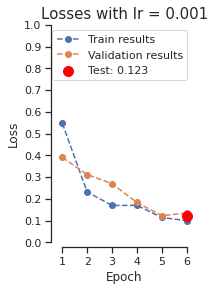

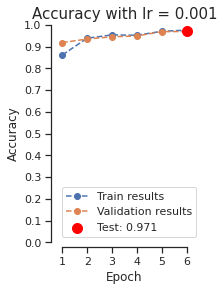

In [14]:
# cost function
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=model_config['lr'])
# optimizer = torch.optim.Adam(model.parameters(), lr=model_config['lr'])

# LR Scheduler
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=model_config['patience'], mode='min',
#     factor=1e-1, min_lr=1e-4, verbose=True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=4 )
# lr_scheduler = None

# run_training_testing arguments
kwargs = {
    'model': model,
    'loss_function': loss_function,
    'optimizer': optimizer,
    'lr_scheduler': lr_scheduler,
    'map_classes': map_classes,
    'skip_classes': skip_classes,
    'device': device,
    'model_path': path_savedModels / f"{DATASET}_{PREFIX}.pth.tar",
    'train_dataloader': train_dataloader,
    'val_dataloader': val_dataloader,
    'test_dataloader': test_dataloader,
    'config': model_config,
    'model_file': modelWriter,
    'epoch_file': epochWriter
}

# train
train_losses, val_losses, train_accs, val_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = run_training_testing(**kwargs)

In [15]:
# close log files
close_wrtier(modelFile, epochFile, modelWriter, epochWriter)

# Exporting last hidden layer data

In [21]:
# create empty model
model = MNIST_Model(**model_setup)
model.to(device)

# load model
# model_file_name = f'{DATASET}_{PREFIX}-test_acc-{round(test_acc,3)}-test_loss-{round(test_loss,3)}.pth.tar'
model_file_name = 'MNIST_Elastic32-test_acc-0.971-test_loss-0.123.pth.tar'
saved_model_path = path_savedModels / model_file_name
load_checkpoint(model, None, None, saved_model_path)

In [22]:
# export last hidden layer for each data loader

for loader, stage in [
    (train_dataloader, 'train'),
    (val_dataloader, 'val'),
    (test_dataloader, 'test'),
]:
    get_last_hidden_layer(loader, model, device, model.last_hidden_neurons,
                          map_classes, path_lastHiddenLayer_raw, FILENAME_POSTFIX, stage)

# Confusion Matrix

In [18]:
save_confusion_matrix(confusion_matrix_test, path_savedModels, FILENAME_POSTFIX, 'test')

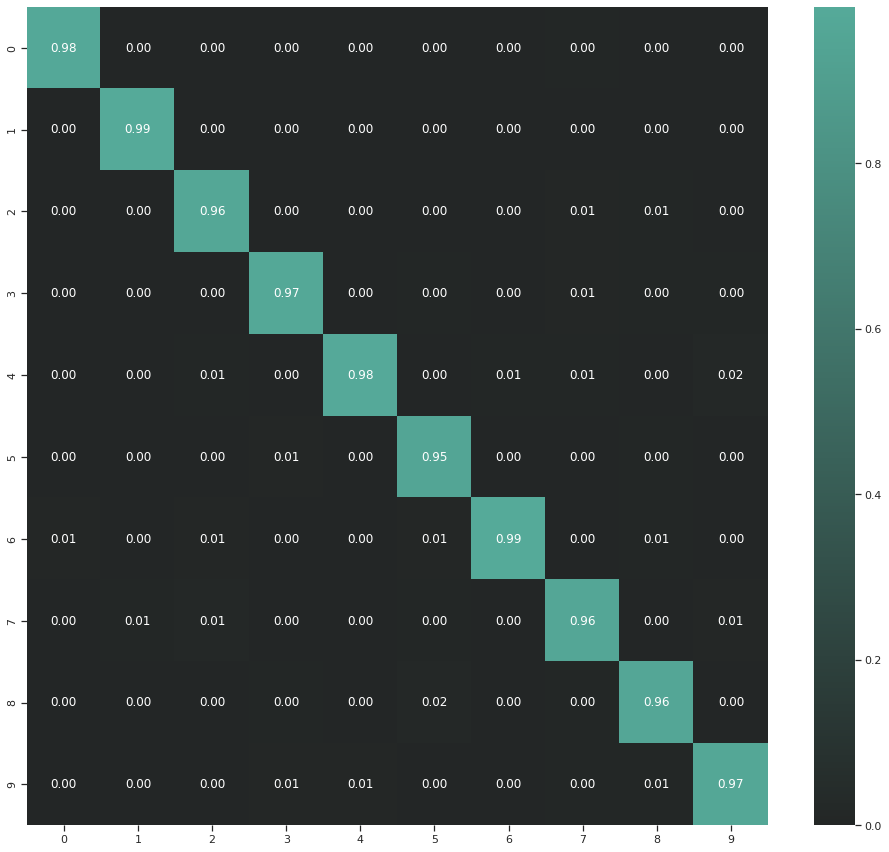

In [19]:
confusion_matrix_test_norm = normalize_confusion_matrix(confusion_matrix_test)
fig, ax = plot_confusion_matrix( confusion_matrix_test_norm, map_classes=map_classes, fmt='.2f')